# Bayesian Model Comparison

Bayesian model comparison quantifies uncertainty about which model generated our data by computing marginal likelihoods that measure how well each model predicts the observations after integrating over all possible parameter values.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide28.png)

# Key Formula

When we cannot condition on which model (or model family) $\text{M}_1$ or $\text{M}_2$ generated our data, we quantify our uncertainty about model choice by calculating **posterior odds**. These represent our updated uncertainty about competing models after observing the data:

$$
\frac{P(\text{M}_1|D)}{P(\text{M}_2|D)} = \frac{P(\text{D}|\text{M}_1)P(\text{M}_1)}{P(\text{D}|\text{M}_2)P(\text{M}_2)}
$$

This can be decomposed as:

$$
\text{Posterior Odds} = \text{Bayes Factor} \times \text{Prior Odds}
$$

Where:
- $P(\text{M}_1|D)$ and $P(\text{M}_2|D)$ are our **posterior uncertainties** about models $\text{M}_1$ and $\text{M}_2$ after conditioning on the observed data
- $\frac{P(\text{D}|\text{M}_1)}{P(\text{D}|\text{M}_2)}$ is the **Bayes factor**, which quantifies the relative evidence the data provides for each model
- $P(\text{M}_1)$ and $P(\text{M}_2)$ are our **prior uncertainties** about each model before conditioning on any data, representing what we cannot know a priori about model choice

# Technical Details

## Bayes Factor

Recall in [Lecture: Bayes factor](https://statfungen.github.io/statgen-primer/Bayes_factor.html), we learn that the **Bayes factor** quantifies the relative evidence data provides for competing models:

$$
\text{BF}_{21} = \frac{L(\text{M}_2|\text{D})}{L(\text{M}_1|\text{D})} ={\frac {\int \Pr(\theta_{2}|M_{2})\Pr(D|\theta_{2},M_{2})\,d\theta _{2}}{\int \Pr(\theta_{1}|M_{1})\Pr(D|\theta_{1},M_{1})\,d\theta _{1}}}
$$

**Interpretation**: 
- $\text{BF}_{21} > 1$: Data favors $\text{M}_2$ over $\text{M}_1$
- $\text{BF}_{21} < 1$: Data favors $\text{M}_1$ over $\text{M}_2$
- $\text{BF}_{21} = 1$: Data uninformative for model choice


## Posterior Odds

The Bayes factor updates prior beliefs about models:

$$
\frac{P(\text{M}_2|D)}{P(\text{M}_1|D)} = \text{BF}_{21} \times \frac{P(\text{M}_2)}{P(\text{M}_1)}
$$

This shows how conditioning on data transforms our uncertainty:

$$
\text{Posterior Uncertainty} = \text{Evidence Update} \times \text{Prior Uncertainty}
$$

## Computing the Marginal Likelihood

The integral $\int \Pr(\theta|\text{M})\Pr(\text{D}|\theta,M)\,d\theta$ is the **marginal likelihood** -- the probability of data under a model, averaged over all parameter values.

**Analytical Solutions**

With conjugate priors (e.g., normal-normal), we obtain closed-form marginal likelihoods.

**Approximation Methods**

For non-conjugate cases, we need numerical approximations:
- **Laplace approximation**: Assumes concentrated posterior around the mode
- **MCMC methods**: Chib's method, thermodynamic integration
- **Nested sampling**: Systematically explores the likelihood surface

The choice reflects a trade-off between computational feasibility and how thoroughly we can characterize the parameter uncertainty in our model comparison.

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [odds ratio](https://statfungen.github.io/statgen-primer/odds_ratio.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [linkage disequilibrium](https://statfungen.github.io/statgen-primer/linkage_disequilibrium.html)
- [marginal and joint effects](https://statfungen.github.io/statgen-primer/marginal_joint_effects.html)
- [Bayes factor](https://statfungen.github.io/statgen-primer/Bayes_factor.html)
- [Bayes rule](https://statfungen.github.io/statgen-primer/Bayes_rule.html)
- [Bayesian normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_normal_mean_model.html)
- [Bayesian multivariate normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_multivariate_normal_mean_model.html)
- [Bayesian mixture model](https://statfungen.github.io/statgen-primer/Bayesian_mixture_model.html)

# Example

## Example 1 -- Fine Mapping

Recall we studied how LD affects our understanding of genetic effects in Example 1 in the [Lecture: marginal and joint effects](https://statfungen.github.io/statgen-primer/marginal_joint_effects.html). We explored two approaches: fitting a joint model with all variants, and performing conditional analysis by iteratively conditioning on the variant with the smallest p-value. Both treated effects as fixed parameters.

In genomics with hundreds of correlated variants in LD, these approaches have critical limitations. Joint models are often infeasible -- there can easily be more variants than samples, making the model unidentifiable. Even when feasible, these models become unstable due to overfitting and collinearity. Conditional analysis, while practical, commits to a single "best" variant at each step without quantifying uncertainty about whether that variant is truly causal.

This is the **fine-mapping** problem: variants in LD are inherited together, creating statistical association between all linked variants even when only one is truly causal. We face fundamental uncertainty about which variant drives the association.

Bayesian model comparison provides a principled framework for this setting. Rather than making sequential conditioning decisions or attempting unstable joint models, we treat causal variant identity as uncertain and systematically evaluate the posterior probability that each variant is causal, properly accounting for the correlation structure in the data.

We define our competing models:

- $\text{M}_0$: Null model -- none of the variants are causal
- $\text{M}_1$: Variant 1 is the causal variant  
- $\text{M}_2$: Variant 2 is the causal variant
- $\text{M}_3$: Variant 3 is the causal variant

### Setup

In [1]:
rm(list = ls())
set.seed(9) 

# Define genotypes for 20 individuals at 3 variants
# Create correlated genotypes to simulate linkage disequilibrium
N = 20
M = 3

# Generate correlated genotype data
# Variant 1 is the true causal variant
# Variants 2 and 3 are in LD with variant 1
variant1 <- sample(0:2, N, replace = TRUE, prob = c(0.4, 0.4, 0.2))
# Create LD: variants 2 and 3 are correlated with variant 1
variant2 <- ifelse(runif(N) < 0.9, variant1, sample(0:2, N, replace = TRUE))
variant3 <- ifelse(runif(N) < 0.8, variant1, sample(0:2, N, replace = TRUE))

Xraw_additive <- cbind(variant1, variant2, variant3)
rownames(Xraw_additive) <- paste("Individual", 1:N)
colnames(Xraw_additive) <- paste("Variant", 1:M)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)

# Generate phenotype where only Variant 1 has a true causal effect
true_beta1 <- 1.5
epsilon <- rnorm(N, mean = 0, sd = 0.5)
Y_raw <- X[, 1] * true_beta1 + epsilon  # Only variant 1 affects the trait

# Standardize phenotype
Y <- scale(Y_raw)

Notice how we've created linkage disequilibrium - variants 2 and 3 are correlated with variant 1, but only variant 1 actually causes the phenotype.

Now we need to define our statistical models. For each model $M_k$ (where $k$ indexes the causal variant), we assume:

- **Likelihood**: $y_i | \beta, \sigma^2, M_k \sim N(X_k\beta, \sigma^2)$, where $X_k$ is the genotype for variant $k$
- **Prior for genetic effect**: $\beta | M_k \sim N(0, \tau^2)$ with $\tau^2 = 1$
- **Prior for error variance**: $\sigma^2 | M_k \sim \text{Inverse-Gamma}(a, b)$ with $a = 2$, $b = 1$

### Prior Distribution

In [2]:
# Bayesian model setup
# We'll use conjugate priors for computational convenience

# Prior parameters for genetic effect (beta)
beta_prior_mean <- 0
beta_prior_var <- 1  # tau^2 in the notes

# Assume equal prior probabilities for all models
prior_probs <- rep(0.25, 4)  # Equal priors for M0, M1, M2, M3

# Prior parameters for error variance (sigma^2)
# Using inverse-gamma: IG(a, b)
sigma2_prior_a <- 2
sigma2_prior_b <- 1

### Computing Marginal Likelihoods and Bayes Factors

The key to Bayesian model comparison is computing the marginal likelihood for each model. This quantity represents how well each model explains the data after integrating out uncertainty in the parameters.

For our conjugate normal-inverse-gamma setup, the marginal likelihood has a closed-form solution, allowing us to compute it analytically rather than relying on numerical approximations.

In [3]:
# Function to compute marginal likelihood for each single-variant model
# Uses conjugate normal-inverse-gamma priors for analytical tractability
compute_marginal_likelihood <- function(X_variant, Y) {
  n <- length(Y)
  
  # Posterior parameters under normal-inverse-gamma conjugacy
  V_n <- 1 / (1/beta_prior_var + sum(X_variant^2))
  mu_n <- V_n * (beta_prior_mean/beta_prior_var + sum(X_variant * Y))
  
  a_n <- sigma2_prior_a + n/2
  b_n <- sigma2_prior_b + 0.5 * (sum(Y^2) + 
                                  beta_prior_mean^2/beta_prior_var - 
                                  mu_n^2/V_n)
  
  # Log marginal likelihood (closed-form for conjugate priors)
  log_ml <- -n/2 * log(2*pi) + 
            0.5 * log(V_n/beta_prior_var) +
            sigma2_prior_a * log(sigma2_prior_b) - 
            a_n * log(b_n) +
            lgamma(a_n) - lgamma(sigma2_prior_a)
  
  return(log_ml)
}

# Compute marginal likelihoods for each model
log_ml_M0 <- compute_marginal_likelihood(rep(0, N), Y)  # Null model (no causal variant)
log_ml_M1 <- compute_marginal_likelihood(X[,1], Y)      # Variant 1 is causal
log_ml_M2 <- compute_marginal_likelihood(X[,2], Y)      # Variant 2 is causal  
log_ml_M3 <- compute_marginal_likelihood(X[,3], Y)      # Variant 3 is causal

# Store results
log_marginal_likelihoods <- c(log_ml_M0, log_ml_M1, log_ml_M2, log_ml_M3)
names(log_marginal_likelihoods) <- c("M0 (Null)", "M1 (Var1)", "M2 (Var2)", "M3 (Var3)")

Now we can compute Bayes factors to compare models.

In [4]:
# Compute all Bayes factors
BF_M1_vs_M0 <- exp(log_ml_M1 - log_ml_M0)
BF_M2_vs_M0 <- exp(log_ml_M2 - log_ml_M0)
BF_M3_vs_M0 <- exp(log_ml_M3 - log_ml_M0)
BF_M1_vs_M2 <- exp(log_ml_M1 - log_ml_M2)
BF_M1_vs_M3 <- exp(log_ml_M1 - log_ml_M3)
BF_M2_vs_M3 <- exp(log_ml_M2 - log_ml_M3)

# Create single dataframe with all comparisons
bf_results <- data.frame(
  Comparison = c("M1 vs M0", "M2 vs M0", "M3 vs M0", 
                 "M1 vs M2", "M1 vs M3", "M2 vs M3"),
  Bayes_Factor = c(BF_M1_vs_M0, BF_M2_vs_M0, BF_M3_vs_M0,
                   BF_M1_vs_M2, BF_M1_vs_M3, BF_M2_vs_M3),
  Log_BF = c(log_ml_M1 - log_ml_M0, log_ml_M2 - log_ml_M0, log_ml_M3 - log_ml_M0,
             log_ml_M1 - log_ml_M2, log_ml_M1 - log_ml_M3, log_ml_M2 - log_ml_M3)
)

print("Bayes Factors (BF > 1 favors first model):")
bf_results

[1] "Bayes Factors (BF > 1 favors first model):"


Comparison,Bayes_Factor,Log_BF
<chr>,<dbl>,<dbl>
M1 vs M0,6.783402e+06,15.729989
M2 vs M0,4.059365e+00,1.401026
M3 vs M0,7.763487e+03,8.957187
M1 vs M2,1.671050e+06,14.328963
M1 vs M3,8.737571e+02,6.772802
M2 vs M3,5.228790e-04,-7.556160


### Posterior Distribution

We now combine the prior probabilities with the Bayes factors to obtain posterior probabilities for each model. This tells us, given the data, how probable each model is.

In [5]:
# Compute posterior probabilities
# Use log-sum-exp trick to avoid numerical overflow
max_log_ml <- max(log_marginal_likelihoods)
scaled_ml <- exp(log_marginal_likelihoods - max_log_ml)

# Apply Bayes' rule: posterior ∝ prior × likelihood
unnormalized_posterior <- prior_probs * scaled_ml
posterior_probs <- unnormalized_posterior / sum(unnormalized_posterior)

# Create results dataframe
posterior_results <- data.frame(
  Model = c("M0 (Null)", "M1 (Var1)", "M2 (Var2)", "M3 (Var3)"),
  Prior = prior_probs,
  Log_Marginal_Likelihood = log_marginal_likelihoods,
  Posterior = posterior_probs
)

print("Posterior Model Probabilities:")
posterior_results

# Identify most probable model
best_model_idx <- which.max(posterior_probs)
print(paste("Most probable model:", posterior_results$Model[best_model_idx]))
print(paste("Posterior probability:", round(posterior_probs[best_model_idx], 4)))

[1] "Posterior Model Probabilities:"


,Model,Prior,Log_Marginal_Likelihood,Posterior
,<chr>,<dbl>,<dbl>,<dbl>
M0 (Null),M0 (Null),0.25,-29.09297,1.472500e-07
M1 (Var1),M1 (Var1),0.25,-13.36298,9.988561e-01
M2 (Var2),M2 (Var2),0.25,-27.69194,5.977415e-07
M3 (Var3),M3 (Var3),0.25,-20.13578,1.143174e-03


[1] "Most probable model: M1 (Var1)"
[1] "Posterior probability: 0.9989"


In this example, we demonstrated how Bayesian model comparison solves the fine-mapping problem. Even when variants are in LD and all show association with the phenotype, our method identified the true causal variant by systematically comparing models and quantifying uncertainty in parameter estimates.

The key insight is that the Bayes factor naturally penalizes model complexity -- a model must fit the data substantially better to justify additional parameters. This helps distinguish true causation from correlation due to LD.

This approach forms the foundation for modern fine-mapping methods in genomics.

## Example 2 -- Detecting pleiotropy

Recall our [Lecture: Bayesian multivariate normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_multivariate_normal_mean_model.html) example where one genetic variant could affect two traits (height and weight). 

In practice, this variant could affect height and weight $\boldsymbol{\beta} = (\beta_1, \beta_2)$ in multiple ways:

- $\text{M}_0$ (No effect): $\boldsymbol{\beta} = (0, 0)$
- $\text{M}_1$ (Height Only): $\beta_2 = 0$
- $\text{M}_2$ (Weight Only): $\beta_1 = 0$
- $\text{M}_3$ (Perfect Correlation): $\text{cor}(\beta_1, \beta_2) = 1$
- $\text{M}_4$ (Weak Correlation): $\text{cor}(\beta_1, \beta_2) = 0.1$
- $\text{M}_5$ (Medium Correlation): $\text{cor}(\beta_1, \beta_2) = 0.5$
- $\text{M}_6$ (Strong Correlation): $\text{cor}(\beta_1, \beta_2) = 0.8$
- ...

We cannot condition on which model generated our data. Bayesian model comparison allows us to quantify uncertainty across these competing hypotheses by computing marginal likelihoods $P(\text{D}|\text{M})$ for each model, integrating over all possible parameter values.

### Setup

Let's simulate data where we know the truth - the variant has a medium correlation effect (M5).

In [6]:
rm(list = ls())
library(MASS)
library(mvtnorm)
library(ggplot2)
set.seed(91)

In [7]:
# Data Generation for Bayesian Model Comparison
# Scenario: One variant affecting two traits (height and weight) with correlated effects

# ============================================================================
# Parameters
# ============================================================================
N <- 100                  # Sample size
true_correlation <- 0.5   # True correlation between effects on height and weight (Model 5)
effect_variance <- 0.25   # Variance for each effect

# ============================================================================
# Step 1: Generate correlated effect sizes
# ============================================================================
# Covariance matrix for bivariate effects
Sigma_effects <- matrix(c(effect_variance, 
                         true_correlation * effect_variance,
                         true_correlation * effect_variance, 
                         effect_variance), 
                       nrow = 2, ncol = 2)

# Draw true effects from multivariate normal
beta_true <- mvrnorm(1, mu = c(2, 3), Sigma = Sigma_effects)
true_beta_height <- beta_true[1]  # Effect on height
true_beta_weight <- beta_true[2]  # Effect on weight

cat("Generated effect sizes:\n")
cat("Effect on height (beta1):", round(true_beta_height, 3), "\n")
cat("Effect on weight (beta2):", round(true_beta_weight, 3), "\n")

# ============================================================================
# Step 2: Generate genotype data
# ============================================================================
# Genotype coding: 0, 1, 2 copies of effect allele
minor_allele_freq <- 0.3
genotypes <- rbinom(N, size = 2, prob = minor_allele_freq)

# ============================================================================
# Step 3: Generate phenotype data
# ============================================================================
# Residual covariance matrix (environmental effects)
Sigma_residual <- matrix(c(1.0, 0.2,    # Height variance = 1.0
                          0.2, 0.8),    # Weight variance = 0.8, covariance = 0.2
                        nrow = 2, ncol = 2)

# Generate correlated residual errors
residual_errors <- mvrnorm(N, mu = c(0, 0), Sigma = Sigma_residual)

# Generate phenotypes: Y = baseline + genetic effect + residual error
baseline_height <- 170  # cm
baseline_weight <- 70   # kg

height <- baseline_height + genotypes * true_beta_height + residual_errors[, 1]
weight <- baseline_weight + genotypes * true_beta_weight + residual_errors[, 2]

# Combine and center phenotypes
phenotypes <- cbind(height, weight)
phenotypes_scaled <- scale(phenotypes, scale = FALSE)
colnames(phenotypes_scaled) <- colnames(phenotypes) <- c("Height", "Weight")

Generated effect sizes:
Effect on height (beta1): 2.181 
Effect on weight (beta2): 4.416 


### Prior Distribution

We'll define all possible models as prior covariance matrices for the effect sizes.

In [8]:
# ============================================================================
# Prior Setup: Define Models and Prior Probabilities
# ============================================================================

# Define prior covariance matrices for beta = (beta_1, beta_2)
# Each model specifies a different structure for how effects covary
models <- list(
  M0 = matrix(c(0, 0, 
                0, 0), 
              nrow = 2, ncol = 2),  # Null: no effect
  
  M1 = matrix(c(effect_variance, 0, 
                0, 0), 
              nrow = 2, ncol = 2),  # Height only: beta_2 = 0
  
  M2 = matrix(c(0, 0, 
                0, effect_variance), 
              nrow = 2, ncol = 2),  # Weight only: beta_1 = 0
  
  M3 = matrix(c(effect_variance, effect_variance,
                effect_variance, effect_variance), 
              nrow = 2, ncol = 2),  # Perfect correlation: beta_2 = beta_1
  
  M4 = matrix(c(effect_variance, 0.1 * effect_variance,
                0.1 * effect_variance, effect_variance), 
              nrow = 2, ncol = 2),  # Weak correlation: cor = 0.1
  
  M5 = matrix(c(effect_variance, 0.5 * effect_variance,
                0.5 * effect_variance, effect_variance), 
              nrow = 2, ncol = 2),  # Medium correlation: cor = 0.5
  
  M6 = matrix(c(effect_variance, 0.8 * effect_variance,
                0.8 * effect_variance, effect_variance), 
              nrow = 2, ncol = 2)   # Strong correlation: cor = 0.8
)

# Initialize results dataframe with model names and equal priors
results_df <- data.frame(
  Model = names(models),
  Prior = rep(1/length(models), length(models)),
  stringsAsFactors = FALSE
)

cat("\nPrior probabilities (equal for all models):\n")
results_df


Prior probabilities (equal for all models):


Model,Prior
<chr>,<dbl>
M0,0.1428571
M1,0.1428571
M2,0.1428571
M3,0.1428571
M4,0.1428571
M5,0.1428571
M6,0.1428571


In [9]:
# Function to compute prior probability when we condition on specific beta values
log_prior <- function(beta, component_cov_matrix) {
  if (all(component_cov_matrix == 0)) {
    # For null model: prior probability is 1 if beta = (0,0), 0 otherwise
    return(ifelse(all(abs(beta) < 0.01), 0, -Inf))
  }
  
  # Add small regularization for numerical stability
  cov_matrix <- component_cov_matrix + diag(1e-6, 2)
  lp <- -0.5 * t(beta) %*% solve(cov_matrix) %*% beta - 
        0.5 * log(det(2 * pi * cov_matrix))
  return(as.numeric(lp))
}

### Computing Marginal Likelihood and Bayes Factor

When we cannot condition on the true parameter values, we must integrate over all possibilities to compute marginal likelihoods. This integration captures our uncertainty about parameters within each model.


In [10]:
# ============================================================================
# Computing Marginal Likelihoods
# ============================================================================

# Compute marginal likelihood: P(Data | M) = integral of P(Data | beta, M) * P(beta | M)
compute_marginal_likelihood <- function(model_name, genotypes, phenotypes, residual_cov) {
  prior_cov <- models[[model_name]]

  # Special case: Null model has beta = (0, 0) with probability 1
  if (model_name == "M0") {
    beta <- c(0, 0)
    log_lik <- compute_log_likelihood(beta, genotypes, phenotypes, residual_cov)
    log_prior_val <- log_prior(beta, prior_cov)
    return(log_lik + log_prior_val)
  }

  # Non-null models: Integrate over all possible beta values
  # Create grid for numerical integration
  beta_range <- seq(-8, 8, length.out = 100)
  grid <- expand.grid(beta1 = beta_range, beta2 = beta_range)
  grid_spacing <- (beta_range[2] - beta_range[1])^2

  # Evaluate integrand at each grid point: likelihood * prior
  log_integrand <- apply(grid, 1, function(beta_vals) {
    beta <- c(beta_vals[1], beta_vals[2])
    log_lik <- compute_log_likelihood(beta, genotypes, phenotypes, residual_cov)
    log_prior_val <- log_prior(beta, prior_cov)
    return(log_lik + log_prior_val)
  })

  # Numerical integration using log-sum-exp trick for numerical stability
  max_log <- max(log_integrand[is.finite(log_integrand)])
  if (!is.finite(max_log)) return(-Inf)

  log_sum <- max_log + log(sum(exp(log_integrand - max_log), na.rm = TRUE))
  log_marginal <- log_sum + log(grid_spacing)  # Account for grid spacing

  return(log_marginal)
}

In [11]:
# Compute log-likelihood: P(Data | beta, M) - CORRECTED VECTORIZATION
compute_log_likelihood <- function(beta, genotypes, phenotypes, residual_cov) {
  N <- nrow(phenotypes)
  
  # Compute all predictions: each row i gets genotypes[i] * beta
  # genotypes is Nx1, beta is length 2, predicted should be Nx2
  predicted <- genotypes %*% t(beta)  # This gives N x 2 matrix correctly
  residuals <- phenotypes - predicted  # N x 2 matrix
  
  # Pre-compute for efficiency
  residual_cov_inv <- solve(residual_cov)
  log_det_term <- -0.5 * log(det(2 * pi * residual_cov))
  
  # Compute quadratic form for each observation
  log_lik <- sum(apply(residuals, 1, function(r) {
    -0.5 * t(r) %*% residual_cov_inv %*% r
  })) + N * log_det_term
  
  return(log_lik)
}

In [12]:
# Compute marginal likelihoods for all models and add to results dataframe
log_marginal_likelihoods <- sapply(names(models), function(model_name) {
  compute_marginal_likelihood(model_name, genotypes, phenotypes_scaled, Sigma_residual)
})

# Add log marginal likelihoods to the dataframe
results_df$Log_ML <- round(log_marginal_likelihoods, 2)

cat("\nLog Marginal Likelihoods:\n")
results_df


Log Marginal Likelihoods:


Model,Prior,Log_ML
<chr>,<dbl>,<dbl>
M0,0.1428571,-728.47
M1,0.1428571,-3966.54
M2,0.1428571,-3754.45
M3,0.1428571,-498.04
M4,0.1428571,-461.11
M5,0.1428571,-459.43
M6,0.1428571,-462.80


### Posterior Distribution

In [13]:
# ============================================================================
# Posterior Probabilities and Model Comparison
# ============================================================================

# Step 1: Compute unnormalized posterior (log scale)
# Posterior ∝ Likelihood × Prior
log_posterior_unnorm <- log_marginal_likelihoods + log(results_df$Prior)

# Step 2: Normalize to obtain proper posterior probabilities
# Use log-sum-exp trick for numerical stability
max_log_post <- max(log_posterior_unnorm)
posterior_probs <- exp(log_posterior_unnorm - max_log_post)
posterior_probs <- posterior_probs / sum(posterior_probs)

# Step 3: Calculate Bayes factors relative to null model (M0)
# BF > 1 indicates evidence in favor of the model vs null
log_bayes_factors <- log_marginal_likelihoods - log_marginal_likelihoods["M0"]
bayes_factors <- exp(log_bayes_factors)

# Add posterior probabilities and Bayes factors to the dataframe
results_df$Posterior <- round(posterior_probs, 4)
results_df$BF_vs_M0 <- round(bayes_factors, 2)

# ============================================================================
# Summary Results
# ============================================================================

cat("\nBayesian Model Comparison Results:\n")
results_df

cat("\n\nMost probable model:", results_df$Model[which.max(posterior_probs)])
cat("\nPosterior probability:", round(max(posterior_probs), 4), "\n")


Bayesian Model Comparison Results:


Model,Prior,Log_ML,Posterior,BF_vs_M0
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
M0,0.1428571,-728.47,0.0000,1.000000e+00
M1,0.1428571,-3966.54,0.0000,0.000000e+00
M2,0.1428571,-3754.45,0.0000,0.000000e+00
M3,0.1428571,-498.04,0.0000,1.185428e+100
M4,0.1428571,-461.11,0.1527,1.300474e+116
M5,0.1428571,-459.43,0.8194,6.978252e+116
M6,0.1428571,-462.80,0.0279,2.380039e+115




Most probable model: M5
Posterior probability: 0.8194 


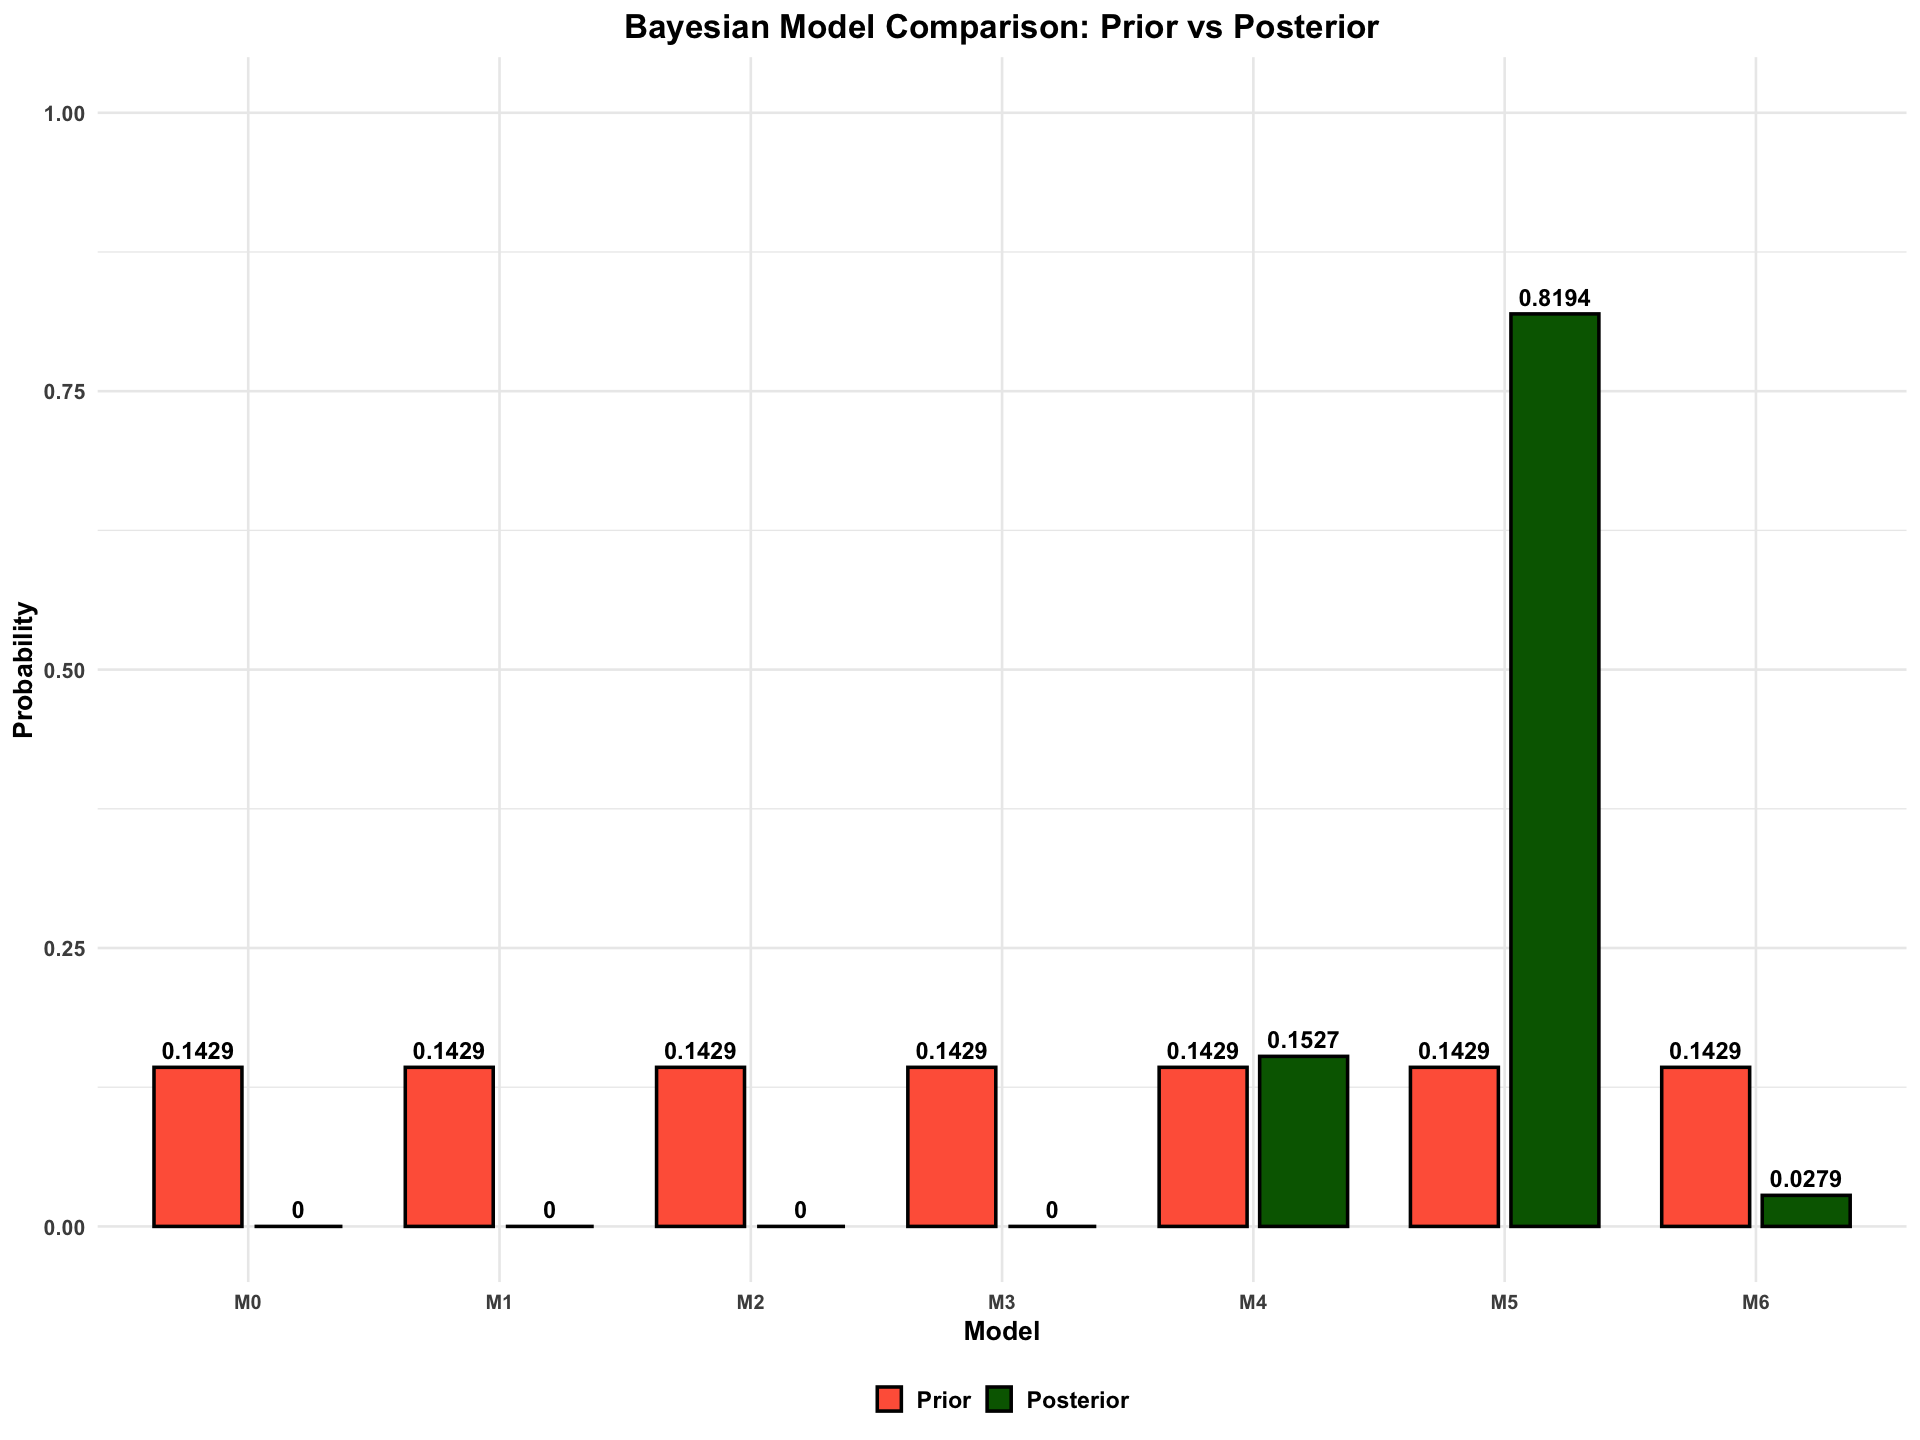

In [14]:
options(repr.plot.width = 16, repr.plot.height = 12)
# Create plotting data with both prior and posterior from results_df
plot_data <- data.frame(
  Model = rep(results_df$Model, 2),
  Probability = c(results_df$Prior, results_df$Posterior),
  Type = factor(rep(c("Prior", "Posterior"), each = nrow(results_df)), 
                levels = c("Prior", "Posterior"))
)

# Create barplot with prior and posterior side-by-side
p <- ggplot(plot_data, aes(x = Model, y = Probability, fill = Type)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.7, color = "black", linewidth = 1) +
  geom_text(aes(label = round(Probability, 4)), 
            position = position_dodge(width = 0.8), vjust = -0.5, size = 5, fontface = "bold") +
  scale_fill_manual(values = c("Prior" = "tomato", "Posterior" = "darkgreen")) +
  labs(
    title = "Bayesian Model Comparison: Prior vs Posterior",
    y = "Probability",
    x = "Model",
    fill = ""
  ) +
  ylim(0, 1) +
  theme_minimal(base_size = 16) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold", size = 12),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold", size = 14),
    legend.position = "bottom",
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

print(p)

In [15]:
ggsave("./figures/Bayesian_model_comparison.png", plot = p, 
       width = 12, height = 8, 
       bg = "transparent", 
       dpi = 300)
